In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import time

# Utility Function

In [2]:
def calculate_distance(val1, val2):
    """
    calculate distance based on manhattan distance
    input : 
        val1,val2:list
    output :
        dist : float
    """
    dist=0
    for i in range(len(val1)):
        dist += (val1[i]-val2[i])**2
    return dist**0.5
def closest_distance(val, centroids, ret='centroid'):
    """
    find closest centroid from data point
    input :
        val : list of features from data point
        centroids : all possible centroid from kmeans
        ret : string if want to return min_dist  or min_centroid
    output :
        min_centroid : closest centroid from data
    """
    min_dist = 10000
    for centroid in centroids:
        dist = calculate_distance(val, centroid)
        if dist<min_dist:
            min_dist=dist
            min_centroid = centroid
    if ret=='centroid':
        return min_centroid
    else:
        return min_dist
def residual_error(transformed_rdd):
    "calculate average residual error from each data to the closest mean"
    n = transformed_rdd.count()
    #calculate residual error for each data
    residual_rdd = transformed_rdd.map(lambda x: (1, calculate_distance(x[0], x[1][0])))
    residual_rdd = residual_rdd.map(lambda x:(x[0], 0 if np.isnan(x[1]) else x[1]))
    #reduced
    residual_rdd = residual_rdd.reduceByKey(lambda x,y:x+y)
    error = residual_rdd.collect()[0][1]/n
    return error

In [21]:
def predict(data, centroids):
    """
    assign label to data based on the centroid from kmeans
    input : 
        data : RDD
    output :
        labels : list of labels
    """
    labels = data.map(lambda x : centroids.index(list(tuple(closest_distance(x, centroids)))))
    return labels.collect()

# Standard KMeans Function

In [ ]:
def add_func(val1, val2):
    return (np.array(np.sum([val1[0], val2[0]], axis=0)), val1[1]+val2[1])

In [3]:
def init_centroid(k, data):
    CENTROIDS = data.takeSample(withReplacement=False, num=k, seed=42)
    return CENTROIDS

In [4]:
def kmeans(k, iteration, data, centroids=None):
    """
    standard kmeans algo with RDD based programming
    input : 
        k : int to determine how many centroids
        iteration : int to determine how many iteration before converge
        data : RDD the data to search the centroid
        centroids : None if use standard kmeans, list of list if use kmeans++
    output :
        CENTROIDS : list of list for the converged centroid
    """
    #init
    #this means we use standard kmeans
    if centroids==None:
        CENTROIDS = init_centroid(k, data)
    #this means we use kmeans++
    else:
        CENTROIDS = centroids
    for iter in range(iteration):
        #mapping
        transformed_rdd = data.map(lambda x:(tuple(closest_distance(x, CENTROIDS)), (x, 1)))
        #reduced
        reduced_rdd = transformed_rdd.reduceByKey(add_func)
        new_centroid = reduced_rdd.map(lambda x : (CENTROIDS.index(list(x[0])), x[1][0]/x[1][1]))
        for centroid in new_centroid.collect():
            CENTROIDS[centroid[0]] = centroid[1].tolist()
        error = residual_error(transformed_rdd)
        print('-'*20, f'iteration-{iter}','-'*20)
        print(error)
    return CENTROIDS

# KMeans++

In [7]:
def reduce_kmean_plus(val1, val2):
    p1 = val1[1]
    p2 = val2[1]
    total_p = p1+p2
    rand_idx = np.random.choice([0, 1], size=1, p=[p1/(total_p), p2/(total_p)])[0]
    if rand_idx ==0:
        return (val1[0], total_p)
    else:
        return (val2[0], total_p)

In [8]:
def init_centroid_kmean_plus(k, data):
    """
    initialize centroid based on kmeans++ method
    input :
        k : int
        data : RDD
    output :
        CENTROID : initial k centroid for kmeans++
    """
    #for the first centroid
    CENTROID = init_centroid(1, data)
    for i in range(k-1):
        mapped = data.map(lambda x: (1, (x, closest_distance(x, CENTROID, ret='dist'))))
        reduced = mapped.reduceByKey(reduce_kmean_plus)
        new_centroid = reduced.collect()[0][1][0]
        CENTROID.append(new_centroid)
    return CENTROID

In [9]:
def kmean_plus(k, iteration, data):
    CENTROID = init_centroid_kmean_plus(k, data)
    converged_centroid = kmeans(k, iteration, data, CENTROID)
    return converged_centroid

# Test Data Dummy

In [10]:
#init
features = 2
sample = 1000
k = 3
iteration = 5
#standard kmeans
data = [[random.randint(1, 100) for i in range(features)] for j in range(sample)]
data = sc.parallelize(data)
means = kmeans(k, iteration, data)

-------------------- iteration-0 --------------------
25.857841837662598
-------------------- iteration-1 --------------------
24.269950262541354
-------------------- iteration-2 --------------------
23.93219091124837
-------------------- iteration-3 --------------------
23.880028283907958
-------------------- iteration-4 --------------------
23.867060336558996


In [11]:
#init
features = 2
sample = 1000
k = 3
iteration = 5
#kmeans++
data = [[random.randint(1, 100) for i in range(features)] for j in range(sample)]
data = sc.parallelize(data)
means = kmean_plus(k, iteration, data)

-------------------- iteration-0 --------------------
24.16089622610127
-------------------- iteration-1 --------------------
23.862386548347683
-------------------- iteration-2 --------------------
23.7851192606482
-------------------- iteration-3 --------------------
23.773934675178488
-------------------- iteration-4 --------------------
23.7575998327822


In [12]:
labels = predict(data, means)

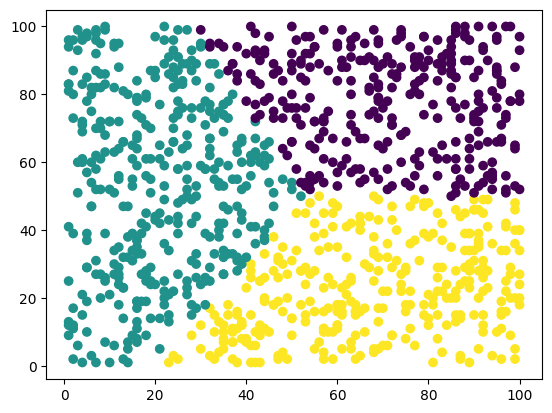

In [13]:
np_data = np.array(data.collect())
plt.scatter(x=np_data[:, 0], y=np_data[:,1], c=labels)

# Testing ke Data CSV

In [14]:
from pyspark.sql import SparkSession  

In [15]:
spark = SparkSession.builder.getOrCreate()  

In [16]:
df = spark.read.csv('all_data.csv', header='true')
df.show(3)

+-------------------+---------------------+-------+----------------+--------------+--------------+--------------+
|Global_active_power|Global_reactive_power|Voltage|Global_intensity|Sub_metering_1|Sub_metering_2|Sub_metering_3|
+-------------------+---------------------+-------+----------------+--------------+--------------+--------------+
|              4.216|                0.418|234.840|          18.400|         0.000|         1.000|          17.0|
|              5.360|                0.436|233.630|          23.000|         0.000|         1.000|          16.0|
|              5.374|                0.498|233.290|          23.000|         0.000|         2.000|          17.0|
+-------------------+---------------------+-------+----------------+--------------+--------------+--------------+
only showing top 3 rows



In [17]:
data = df.toPandas().dropna().astype(float).values.tolist()
data = sc.parallelize(data, numSlices=1000)
data.count()

23/04/28 21:31:16 WARN TaskSetManager: Stage 63 contains a task of very large size (148 KB). The maximum recommended task size is 100 KB.


2049280

In [18]:
#standard kmeans
start_time = time.time()
k = 5
iteration = 4
centroids = kmeans(k, iteration, data)
end_time = time.time()
print(f'{iteration} iteration took {end_time-start_time} seconds')

23/04/28 21:31:28 WARN TaskSetManager: Stage 64 contains a task of very large size (148 KB). The maximum recommended task size is 100 KB.
23/04/28 21:31:43 WARN TaskSetManager: Stage 65 contains a task of very large size (148 KB). The maximum recommended task size is 100 KB.
23/04/28 21:31:55 WARN TaskSetManager: Stage 66 contains a task of very large size (148 KB). The maximum recommended task size is 100 KB.
23/04/28 21:32:24 WARN TaskSetManager: Stage 68 contains a task of very large size (148 KB). The maximum recommended task size is 100 KB.
23/04/28 21:32:40 WARN TaskSetManager: Stage 69 contains a task of very large size (148 KB). The maximum recommended task size is 100 KB.
23/04/28 21:33:06 WARN TaskSetManager: Stage 71 contains a task of very large size (148 KB). The maximum recommended task size is 100 KB.


-------------------- iteration-0 --------------------
4.82755462568016


23/04/28 21:33:30 WARN TaskSetManager: Stage 73 contains a task of very large size (148 KB). The maximum recommended task size is 100 KB.
23/04/28 21:33:40 WARN TaskSetManager: Stage 74 contains a task of very large size (148 KB). The maximum recommended task size is 100 KB.
23/04/28 21:34:11 WARN TaskSetManager: Stage 76 contains a task of very large size (148 KB). The maximum recommended task size is 100 KB.


-------------------- iteration-1 --------------------
4.598926546034529


23/04/28 21:34:45 WARN TaskSetManager: Stage 78 contains a task of very large size (148 KB). The maximum recommended task size is 100 KB.
23/04/28 21:35:00 WARN TaskSetManager: Stage 79 contains a task of very large size (148 KB). The maximum recommended task size is 100 KB.
23/04/28 21:35:36 WARN TaskSetManager: Stage 81 contains a task of very large size (148 KB). The maximum recommended task size is 100 KB.


-------------------- iteration-2 --------------------
4.413116236206256


23/04/28 21:36:03 WARN TaskSetManager: Stage 83 contains a task of very large size (148 KB). The maximum recommended task size is 100 KB.
23/04/28 21:36:15 WARN TaskSetManager: Stage 84 contains a task of very large size (148 KB). The maximum recommended task size is 100 KB.
[Stage 85:==================================================>  (962 + 8) / 1000]

-------------------- iteration-3 --------------------
4.177715820098418
4 iteration took 310.5116379261017 seconds


In [19]:
#kmeans++
start_time = time.time()
k = 5
iteration = 4
centroids = kmean_plus(k, iteration, data)
end_time = time.time()
print(f'{iteration} iteration took {end_time-start_time} seconds')

23/04/28 21:36:39 WARN TaskSetManager: Stage 86 contains a task of very large size (148 KB). The maximum recommended task size is 100 KB.
23/04/28 21:36:50 WARN TaskSetManager: Stage 87 contains a task of very large size (148 KB). The maximum recommended task size is 100 KB.
23/04/28 21:37:01 WARN TaskSetManager: Stage 88 contains a task of very large size (148 KB). The maximum recommended task size is 100 KB.
23/04/28 21:37:27 WARN TaskSetManager: Stage 90 contains a task of very large size (148 KB). The maximum recommended task size is 100 KB.
23/04/28 21:37:54 WARN TaskSetManager: Stage 92 contains a task of very large size (148 KB). The maximum recommended task size is 100 KB.
23/04/28 21:38:18 WARN TaskSetManager: Stage 94 contains a task of very large size (148 KB). The maximum recommended task size is 100 KB.
23/04/28 21:38:44 WARN TaskSetManager: Stage 96 contains a task of very large size (148 KB). The maximum recommended task size is 100 KB.
23/04/28 21:39:08 WARN TaskSetMana

-------------------- iteration-0 --------------------
4.217018184056375


23/04/28 21:40:12 WARN TaskSetManager: Stage 103 contains a task of very large size (148 KB). The maximum recommended task size is 100 KB.
23/04/28 21:40:24 WARN TaskSetManager: Stage 104 contains a task of very large size (148 KB). The maximum recommended task size is 100 KB.
23/04/28 21:40:56 WARN TaskSetManager: Stage 106 contains a task of very large size (148 KB). The maximum recommended task size is 100 KB.


-------------------- iteration-1 --------------------
4.218434756614412


23/04/28 21:41:22 WARN TaskSetManager: Stage 108 contains a task of very large size (148 KB). The maximum recommended task size is 100 KB.
23/04/28 21:41:35 WARN TaskSetManager: Stage 109 contains a task of very large size (148 KB). The maximum recommended task size is 100 KB.
23/04/28 21:41:59 WARN TaskSetManager: Stage 111 contains a task of very large size (148 KB). The maximum recommended task size is 100 KB.


-------------------- iteration-2 --------------------
4.100170286753987


23/04/28 21:42:23 WARN TaskSetManager: Stage 113 contains a task of very large size (148 KB). The maximum recommended task size is 100 KB.
23/04/28 21:42:34 WARN TaskSetManager: Stage 114 contains a task of very large size (148 KB). The maximum recommended task size is 100 KB.
[Stage 115:=================================================>  (961 + 8) / 1000]

-------------------- iteration-3 --------------------
3.800026121825423
4 iteration took 378.18080377578735 seconds


In [22]:
labels = predict(data, means)

23/04/28 21:44:29 WARN TaskSetManager: Stage 116 contains a task of very large size (148 KB). The maximum recommended task size is 100 KB.


# OOP BASED
masih error mager benerin

In [236]:
class KMeans:
    def __init__(self, k, iteration):
        self.k = k
        self.iteration = iteration
    def init_means(self):
        self.MEANS = self.data.takeSample(withReplacement=False, num=self.k, seed=42)
    def fit(self, data):
        self.data = sc.parallelize(data)
        for iter in range(iteration):
            #mapping
            transformed_rdd = self.data.map(lambda x:(tuple(closest_distance(x, self.MEANS)), (x, 1)))
            #reduced
            reduced_rdd = transformed_rdd.reduceByKey(add_func)
            new_means = reduced_rdd.map(lambda x : (self.MEANS.index(list(x[0])), x[1][0]/x[1][1]))
            for mean in new_means.collect():
                self.MEANS[mean[0]] = mean[1].tolist()
    def calculate_distance(self, val1, val2):
        """
        calculate distance based on manhattan distance
        input : 
            val1,val2:list
        output :
            dist : float
        """
        dist=0
        for i in range(len(val1)):
            dist = (val1[i]-val2[i])**2
        return dist**0.5
    def closest_distance(self, val, means):
        """
        find closest mean from val
        input :
            val : list of features from data point
            means : list of list features from current mean
        output :
            min_mean : list of features from closest mean
        """
        min_dist = 10000
        for mean in means:
            dist = calculate_distance(val, mean)
            if dist<min_dist:
                min_dist=dist
                min_mean = mean
        return min_mean